<a href="https://colab.research.google.com/github/shyoonCS/DataAnalysis/blob/main/Report202502.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문제 1-2. API 호출코드 작성

In [2]:
import requests
import pandas as pd

url = "http://openapi.seoul.go.kr:8088/4446516e7973687936367073734f62/json/energyUseDataSummaryInfo/1/5"
api_key = '4446516e7973687936367073734f62'
year_from = 2015
year_to = 2024

params = {
    'KEY': api_key,
    'TYPE': 'json',
    'SERVICE': 'energyUseDataSummaryInfo',
    'START_INDEX': '1',
    'END_INDEX': '9999',
    'YEAR': '2024',
    'MON': '12'
}

## 년도 생성
def get_year_months():
  year_months = []
  for year in range(year_from, year_to+1):
    for month in range(1,12+1):
      year_months.append((f'{year}', f'{month:02d}'))
  return year_months

data = []
cnt_req = 0
cnt_ok = 0
cnt_fail = 0
for year_month in get_year_months() :
  # URL 생성
  url_ym = url + '/' + year_month[0] + '/' + year_month[1]

  ## API 호출 &  데이터 수집
  response = requests.get(url_ym, params=params)
  cnt_req = cnt_req + 1
  if response.status_code == 200:
    cnt_ok = cnt_ok + 1
    data = data + response.json()['energyUseDataSummaryInfo']['row']
  else:
    cnt_fail = cnt_fail + 1

## 호출 결과 출력
print(f"API 결과 : 호출 횟수 : {cnt_req}, 성공 횟수 : {cnt_ok}, 실패 횟수 : {cnt_fail}, 상태코드 : {response.status_code}")

API 결과 : 호출 횟수 : 120, 성공 횟수 : 120, 실패 횟수 : 0, 상태코드 : 200


문제 2-1. DataFrame으로 변환하고, 데이터의 기본 정보를 출력

In [74]:
## 호출 결과 출력
df = pd.DataFrame(data)
#df.to_csv('data.csv', index=False, encoding='utf-8')
#df.to_excel('data.xlsx', index=False)
#df.describe()
#df.info()
df.head()

,YEAR,MON,MM_TYPE,CNT,EUS,EUS1,EUS2,ECO2_1,ECO2_2,GUS,...,WUS1,WUS2,WCO2_1,WCO2_2,HUS,HUS1,HUS2,HCO2_1,HCO2_2,REG_DATE
0,2015,01,개인,767791,193784708,194781915,204969429,-6090964,-2582568.736,59133720,...,12723680.426,12899476.73,8179.308,2715.530256,22740838.937,23400055.303,27090493.875,-2504435.652,-33660084.213069,2015-06-04 17:03:55.0
1,2015,01,학교,1382,134955565,128707423,145561511,-2178902,-923854.448,9107197,...,2097433.8,2133200.8,-39498.1,-13113.3692,0,0,0,0,0,2015-06-04 17:03:55.0
2,2015,01,종교단체,32,372270,363376,411363,-15099.5,-6402.188,53331,...,4548,4519,1411.5,468.618,0,0,0,0,0,2015-06-04 17:03:55.0
3,2015,01,소상공인,2058,10249618,9927610,11039593,-233983.5,-99209.004,536119,...,146480.6,147325.6,369.9,122.8068,0,0,0,0,0,2015-06-04 17:03:55.0
4,2015,01,공동주택관리소,1747,327102096,329852334,351694752,-13671447,-5796693.528,22834274,...,12763070,12979835.8,-26645.4,-8846.2728,0,0,0,0,0,2015-06-04 17:03:55.0


문제 2-2. Data 전처리 : 연도(year)와 계절(season) 컬럼 추가

In [109]:
# 연도컬럼 추가 : YEAR 기 존재, REG_YEAR 추가
df['REG_DATE'] = pd.to_datetime(df['REG_DATE'])
df['REG_YEAR'] = df['REG_DATE'].dt.year

# 계절(SEASON) 컬럼 추가
def f_season(MON) :
  if MON in ['03','04','05'] :
    return '봄'
  elif MON in ['06','07','08'] :
    return '여름'
  elif MON in ['09','10','11'] :
    return '가을'
  elif MON in ['12','01','02'] :
    return '겨울'
  else :
    return 'N/A'

df['SEASON'] = df['MON'].apply(f_season)
df[['YEAR', 'REG_YEAR','MON','SEASON']]


,YEAR,REG_YEAR,MON,SEASON
0,2015,2015,01,겨울
1,2015,2015,01,겨울
2,2015,2015,01,겨울
3,2015,2015,01,겨울
4,2015,2015,01,겨울
...,...,...,...,...
595,2024,2025,12,겨울
596,2024,2025,12,겨울
597,2024,2025,12,겨울
598,2024,2025,12,겨울


문제 3-1. Data 시각화 : 연도별 에너지 사용 총 사용량(전기+가스+수도+지역난방)의 변화

In [9]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


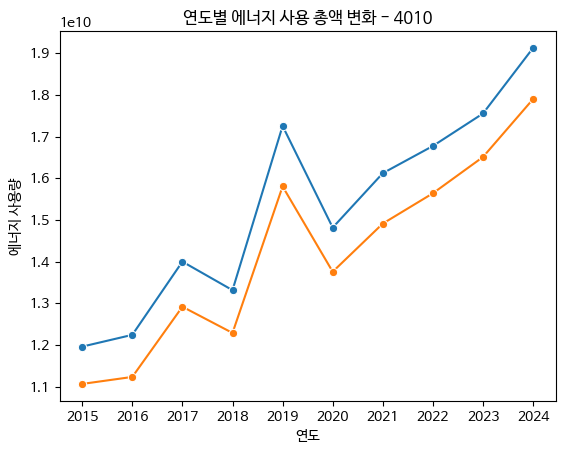

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns #matplotlib 확장

df['EUS'] = pd.to_numeric(df['EUS'])
df['GUS'] = pd.to_numeric(df['GUS'])
df['WUS'] = pd.to_numeric(df['WUS'])
df['HUS'] = pd.to_numeric(df['HUS'])
df['TOTAL'] = df['EUS'] + df['GUS'] + df['WUS'] + df['HUS']
df_total = df.groupby('YEAR')[['TOTAL','EUS','GUS','WUS','HUS']].sum()
#print(df_total)
df.to_excel('data.xlsx', index=False)
df_total.to_excel('total.xlsx')

#plt.figure(figsize=(12, 6))
sns.lineplot(data=df_total, x='YEAR', y='TOTAL', marker='o')
sns.lineplot(data=df_total, x='YEAR', y='EUS', marker='o')
plt.title("연도별 에너지 사용 총액 변화 - 4010")
plt.xlabel("연도")
plt.ylabel("에너지 사용량")
plt.show()


 문제 3-2. 계절별 가스 사용량 평균

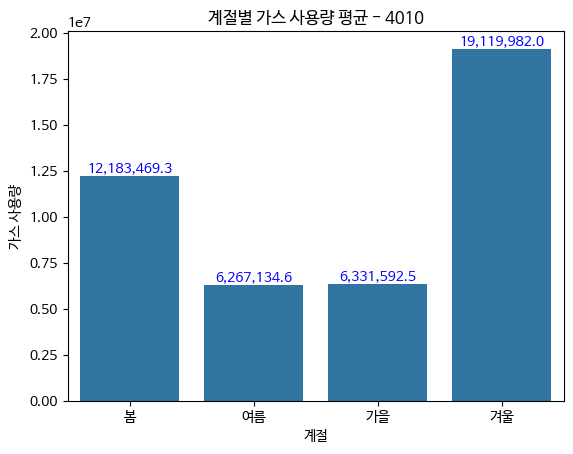

In [73]:
#df_gas = df.groupby('SEASON')['GUS'].mean() #series 컬럼 sorting 불가
df_gas = df.groupby('SEASON', as_index=False)['GUS'].mean()
#계절별 소팅
df_gas['SEASON'] = pd.Categorical(df_gas['SEASON'], categories=['봄','여름','가을','겨울'], ordered = True)
df_gas = df_gas.sort_values('SEASON')

#시각화
ax = sns.barplot(data=df_gas, x='SEASON', y='GUS')
plt.title("계절별 가스 사용량 평균 - 4010")
plt.xlabel("계절")
plt.ylabel("가스 사용량")

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.1f}',  # 소수점 1자리까지 표시
                (p.get_x() + p.get_width() / 2, p.get_height()),  # 위치 조정
                ha='center', va='bottom', fontsize=10, color='blue')
plt.show()


4. 분석

/tmp/ipython-input-1253816335.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2019['TOTAL'] =  df2019['EUS'] + df2019['GUS'] + df2019['WUS'] + df2019['HUS']


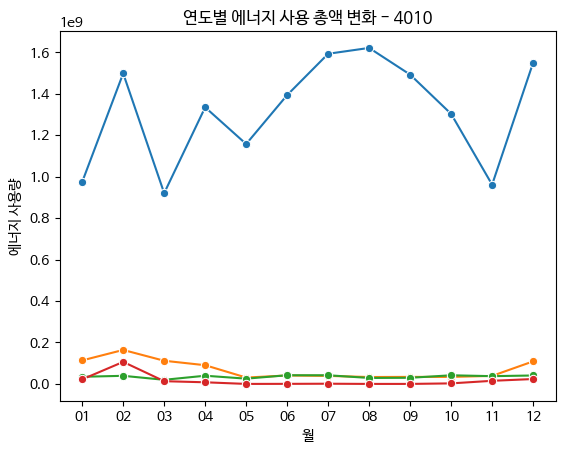

In [142]:

df2019 = df[df['YEAR'] == '2019']
'''
df2019['EUS'] = pd.to_numeric(df2019['EUS'])
df2019['GUS'] = pd.to_numeric(df2019['GUS'])
df2019['WUS'] = pd.to_numeric(df2019['WUS'])
df2019['HUS'] = pd.to_numeric(df2019['HUS'])
'''
df2019['TOTAL'] =  df2019['EUS'] + df2019['GUS'] + df2019['WUS'] + df2019['HUS']
df2019_total = df2019.groupby('MON')[['TOTAL','EUS','GUS','WUS','HUS']].sum()
#plt.figure(figsize=(12, 6))
sns.lineplot(data=df2019_total, x='MON', y='EUS', marker='o')
sns.lineplot(data=df2019_total, x='MON', y='GUS', marker='o')
sns.lineplot(data=df2019_total, x='MON', y='WUS', marker='o')
sns.lineplot(data=df2019_total, x='MON', y='HUS', marker='o')
plt.title("연도별 에너지 사용 총액 변화 - 4010")
plt.xlabel("월")
plt.ylabel("에너지 사용량")
plt.show()


,0
EUS,1.420136e+11
GUS,6.585327e+09
WUS,3.574776e+09
HUS,9.765209e+08


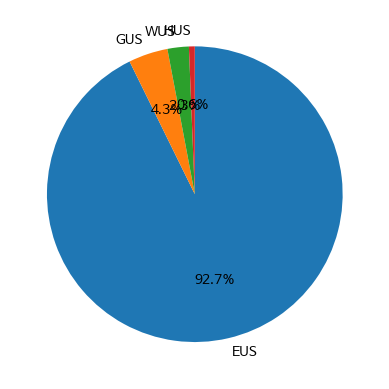

In [157]:
df_total2 = df_total.drop('TOTAL', axis=1)
df_total_sum = df_total2.sum(axis=0)
df_total_sum.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
df_total_sum

/tmp/ipython-input-358379115.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eus['ORDER'] = df_eus['SEASON'].apply(f_seasonorder)


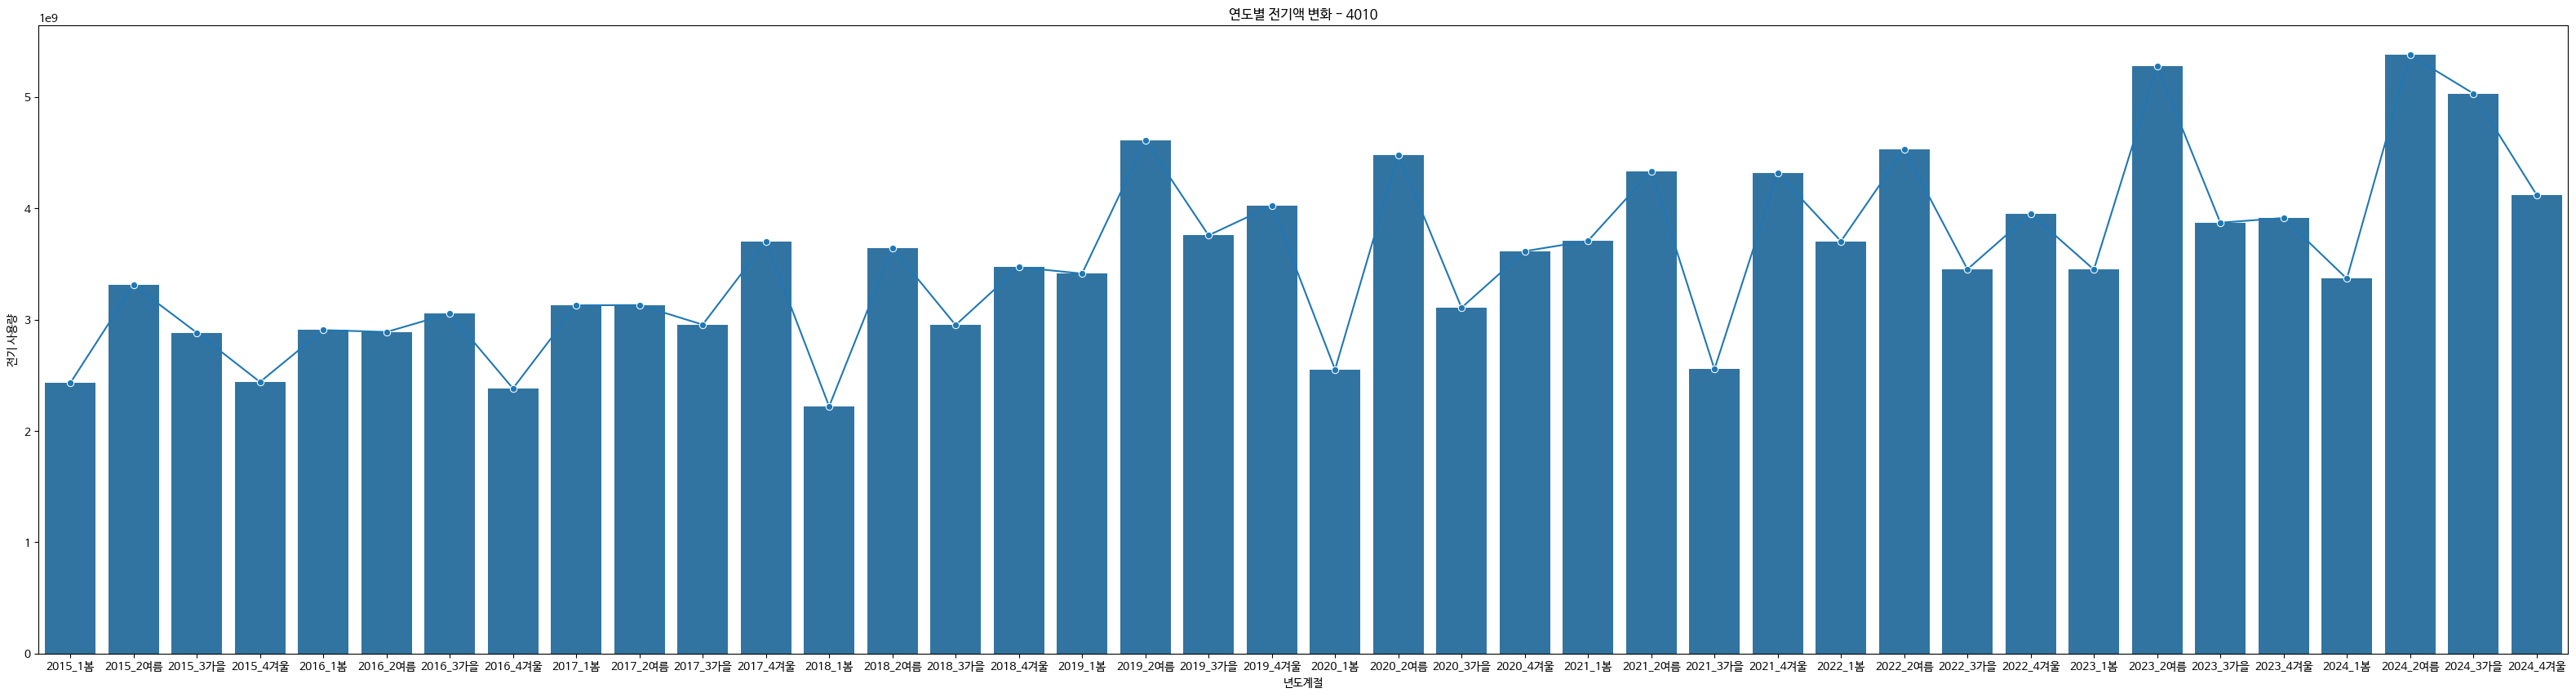

In [199]:
#전기사용량 분석
df_eus = df[['YEAR','MON','SEASON','EUS']]

# 계절(SEASON) 컬럼 추가
def f_seasonorder(SEASON) :
  if SEASON == '봄':
    return 1
  elif SEASON == '여름':
    return 2
  elif SEASON == '가을' :
    return 3
  elif SEASON == '겨울' :
    return 4
  else :
    return 'N/A'

df_eus['ORDER'] = df_eus['SEASON'].apply(f_seasonorder)
df_eus = df_eus.sort_values(by=['YEAR','ORDER', 'MON'], ascending=True)
df_eus['YSEASON'] = df_eus['YEAR'].astype(str) +'_'+  df_eus['ORDER'].astype(str) +df_eus['SEASON']
df_eus
df_eus_sum = df_eus.groupby('YSEASON')[['EUS']].sum()

plt.figure(figsize=(40, 10))
sns.lineplot(data=df_eus_sum, x='YSEASON', y='EUS', marker='o')
sns.barplot(data=df_eus_sum, x='YSEASON', y='EUS')
plt.title("연도별 전기사용량 변화 - 4010")
plt.xlabel("년도계절")
plt.ylabel("전기 사용량")
plt.show()


In [261]:
#계절별 전기사용량 분석
'''
df_eus_spring = df_eus[df_eus['SEASON']== '봄']
df_eus_springtotal = df_eus_spring.groupby('YEAR')[['EUS']].sum()
df_eus_summer = df_eus[df_eus['SEASON']== '여름']
df_eus_summertotal = df_eus_summer.groupby('YEAR')[['EUS']].sum()
df_eus_autumn = df_eus[df_eus['SEASON']== '가을']
df_eus_automntotal = df_eus_autumn.groupby('YEAR')[['EUS']].sum()
df_eus_winter = df_eus[df_eus['SEASON']== '겨울']
df_eus_wintertotal = df_eus_winter.groupby('YEAR')[['EUS']].sum()

plt.figure(figsize=(10, 6))
#sns.lineplot(data=df_eus, x='YEAR', y='EUS', hue ='SEASON', style = 'SEASON')

sns.lineplot(data=df_eus_springtotal, x='YEAR', y='EUS',marker="o" )
sns.lineplot(data=df_eus_summertotal, x='YEAR', y='EUS', marker='^')
sns.lineplot(data=df_eus_automntotal, x='YEAR', y='EUS', marker='o')
sns.lineplot(data=df_eus_wintertotal, x='YEAR', y='EUS', marker='o')

'''
df_pivot = df_eus.pivot(index='YEAR', columns='SEASON', values='EUS')
df_pivot
'''
sns.lineplot(data=df_eus_springtotal, x='YEAR', y='EUS',marker="o", )
plt.title("계절별 전기사용량 변화 - 4010")
plt.xlabel('연도')
plt.ylabel("전기 사용량")
plt.show()

'''

ValueError: Index contains duplicate entries, cannot reshape

<Axes: >

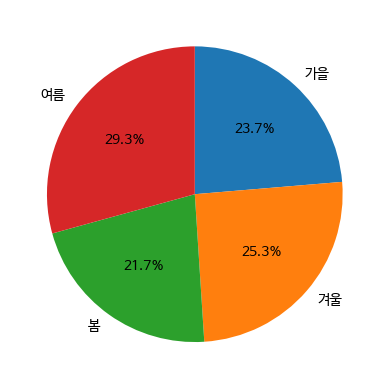

In [225]:
df_eus_season =  df_eus[['SEASON','EUS']]
df_eus_seasonsum = df_eus_season.groupby('SEASON')[['EUS']].sum()

df_eus_seasonsum= df_eus_seasonsum.sum(axis=1)
df_eus_seasonsum.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)

In [ ]:
#pivot

